In [59]:
import scipy as sp
import scipy.stats as sps
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import MDS


In [431]:
# mean and stdev for fields in imdb dataset
imdb_year_stats = (1994.89, 25.97)
imdb_avgrat_stats = (6.19, 1.37)
imdb_numrat_stats = (3657.33, 35609.24)
# box office stats taken from this kaggle dataset
# https://www.kaggle.com/datasets/kalilurrahman/top-box-office-revenue-data-english-movies?resource=download
# and computed from 'Worldwide Lifetime Gross' of top 1000 international movies
# ofc that doesn't add up because we took other stats from all movies and this stat from the most successful
# TODO maybe turn it down a notch and make a mean of idk 1M dollars instead of 400 but increase std
imdb_boxoffice_stats = (404658884.85, 291795184.03 )
# with these it should be possible to recreate real-looking data from zscores, right? multiply by std, add mean.

# some set stats from the imdb dataset
imdb_top_genres = ['Drama', 'Comedy', 'Documentary', 'Romance', 'Action', 'Crime']
imdb_top_genres_freq = [0.46, 0.25, 0.16, 0.11, 0.1, 0.09]

stats={
    'year': imdb_year_stats,
    'avg_rating': imdb_avgrat_stats,
    'num_ratings': imdb_numrat_stats,
    'boxoffice': imdb_boxoffice_stats,
    'top_genres':imdb_top_genres,
    'imdb_top_genres_freq':imdb_top_genres_freq
}

In [432]:
# if the variables are all uncorrelated we can just sample each dimension individually, i think
# so in this cell we define functions to sample the desired 4d space

def rvs(means, sds, limits, size = 10, random_state=None):
    """Returns samples of D truncated normal distributions with the provided means, SDs and limits.
    The distributions are assumed to be independent, hence each dimension is sampled individually.
    The provided limits are assumed to be in sample space (as opposed to standard deviations).
    Note that SD and limits are dependent, i.e., if the limits are too narrow, the SD of the resulting
    distribution will be smaller than what was asked for."""
    D = min(len(means), len(sds), len(limits))
    result = np.empty((size,D))
    for i in range(D):
        l, r = limits[i]
        m = means[i]
        s = sds[i]
        a, b = (l - m) / s, (r - m) / s
        samples = sps.truncnorm.rvs(a,b,loc=m,scale=s,size=size,random_state=random_state)
        result[:,i] = samples
    return result

# quick test seems to work
#import math
#rvs([1,0,0], [1,10,1], limits=[(.5,3), (-math.inf,math.inf), (-2,2)])

In [439]:
# year, avg_rating, num_ratings, box office dollars
import math

nd1 = 20
nd2 = 5
means, sds = list(
    zip(*[imdb_year_stats, imdb_avgrat_stats, imdb_numrat_stats, imdb_boxoffice_stats])
)
limits = [(1890, 2023), (1, 10), (0, math.inf), (0, math.inf)]
samples1 = rvs(means, sds, limits, size=nd1)
# the small cluster has a shifted mean and tighter standard deviations
# TODO make it configurable slash random
# 1) what the direction of the shifted means is
# 2) by how much the means are shifted and along which dimensions
shifted_means = np.array(means) + np.array((0, 2, 2, 0)) * np.array(sds)
smaller_sds = np.array(sds) * np.repeat(0.5, 4)
samples2 = rvs(shifted_means, smaller_sds, limits, size=nd2)
samples = np.concatenate((samples1, samples2))

w = samples[:, 0]
x = samples[:, 1]
y = samples[:, 2]
z = samples[:, 3]

wz = sps.zscore(w)
xz = sps.zscore(x)
yz = sps.zscore(y)
zz = sps.zscore(z)

t = np.concatenate((np.repeat(0, nd1), np.repeat(1, nd2)))
df = pd.DataFrame(
    data={
        "year": w,
        "avg_rating": x,
        "num_ratings": y,
        "box_office": z,
        "t": t,
        "year_z": wz,
        "avg_rating_z": xz,
        "num_ratings_z": yz,
        "box_office_z": zz,
    }
)

for i, g in enumerate(imdb_top_genres):
    freq = imdb_top_genres_freq[i]
    df[g] = sps.binom.rvs(1, freq, size=nd1 + nd2)

# now a bit of postprocessing
# year and num_rating and box office can't be float
for field in ["year", "num_ratings", "box_office"]:
    df[field] = df[field].apply(lambda y: int(y))
# some floats should be rounded
df["avg_rating"] = df["avg_rating"].round(1)
# regarding sets
# we want all sets to have at least one element in each cluster
# which at the same time ensures that no set has a single or no element
genre_colsums = df[imdb_top_genres + ["t"]].groupby("t").sum()
for cluster in range(2):
    for genre in imdb_top_genres:
        count = genre_colsums.loc[cluster, genre]
        if count == 0:
            # take random row of that cluster and add the set there
            randrow_start = 0 if cluster == 0 else nd1
            randrow_end = nd1 if cluster == 0 else nd1 + nd2
            randrow = np.random.choice(
                range(randrow_start, randrow_end), 1, replace=False
            )
            df.loc[randrow[0], genre] = 1
# do the same sort of thing row-wise
# there could be movies not in any set/genre, and we don't want that
for i in range(df.shape[0]):
    while df.loc[i][imdb_top_genres].sum() < 1:
        for j, genre in enumerate(imdb_top_genres):
            # do the drawing again
            freq = imdb_top_genres_freq[j]
            flag = sps.binom.rvs(1, freq, size=1)
            df.loc[i, genre] = flag

df

,year,avg_rating,num_ratings,box_office,t,year_z,avg_rating_z,num_ratings_z,box_office_z,Drama,Comedy,Documentary,Romance,Action,Crime
0,2006,6.2,8705,40500154,0,0.837483,0.598448,1.053059,1.846198,0,0,1,0,0,0
1,1988,5.3,43867,221225576,0,0.164871,1.166251,0.093267,0.884680,1,0,0,0,0,0
2,1995,6.8,45230,227071198,0,0.220566,0.199434,0.137707,0.853580,1,0,0,0,0,0
3,1949,5.9,31552,507712162,0,2.374968,0.769902,0.308198,0.639521,1,0,0,0,0,0
4,2016,6.4,41912,173074831,0,1.399336,0.461284,0.029545,1.140858,0,0,0,1,0,1
5,1961,6.3,6915,470434132,0,1.712189,0.510595,1.111392,0.441190,1,0,0,0,0,0
6,2000,5.5,14769,586682974,0,0.493131,1.073624,0.855339,1.059671,1,0,0,0,0,1
7,2019,5.1,35461,483547442,0,1.602986,1.346589,0.180763,0.510957,1,1,0,0,0,0
8,2008,6.3,6375,493564579,0,0.965489,0.528744,1.128999,0.564251,0,1,0,0,0,0
9,2014,5.1,21920,256260410,0,1.313971,1.344679,0.622208,0.698284,1,0,0,0,0,0


In [251]:
# load imdb dataset to get little known movie names
ratings = pd.read_csv('../imdb/title.ratings.tsv', sep='\t')
movies = pd.read_csv('../imdb/title.basics.tsv', sep="\t", header=0, converters={
    # sucks, but it's mixed data everywhere
    'tconst': str,
    'titleType': str,
    'primaryTitle': str,
    'originalTitle': str,
    'isAdult': str,
    'startYear': str,
    'endYear': str,
    'runtimeMinutes': str,
    'genres': str,
})
movies = movies.query('(isAdult == "0") & (titleType == "movie")')
movie_ratings = pd.merge(ratings, movies, how='inner', on='tconst')
movie_ratings['year'] = movie_ratings['startYear'].apply(lambda s: int(s) if s != '\\N' else -1)
movie_ratings = movie_ratings[movie_ratings['year']>0]
genres = movie_ratings.genres.str.split(',').apply(lambda x:set(x))
all_genres = list(set.union(*genres))
setdist_table = [
    list(map(lambda ag: 1 if ag in i else 0, all_genres)) for i in genres
]
setdist_table = np.array(setdist_table)
set_colsum = np.sum(setdist_table, axis=0)
top_genres = list(sorted(all_genres, key=lambda g: set_colsum[all_genres.index(g)], reverse=True))[:6]
for genre in all_genres:
    movie_ratings[f'{genre}'] = setdist_table[:,all_genres.index(genre)]
# remove the remaining maybe-porns
movie_ratings = movie_ratings.query('Adult == 0')
# now filter for little-known movies, i.e., those with few ratings
movie_ratings = movie_ratings.query('numVotes < 1000')
movie_ratings

,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,...,History,Music,Thriller,Action,Biography,Sport,Musical,Drama,Talk-Show,Western
0,tt0000009,5.3,206,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,...,0,0,0,0,0,0,0,0,0,0
1,tt0000147,5.3,474,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,...,0,0,0,0,0,1,0,0,0,0
2,tt0000502,4.1,15,movie,Bohemios,Bohemios,0,1905,\N,100,...,0,0,0,0,0,0,0,0,0,0
3,tt0000574,6.0,832,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,...,0,0,0,1,1,0,0,0,0,0
4,tt0000591,4.4,20,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289320,tt9916170,7.0,7,movie,The Rehearsal,O Ensaio,0,2019,\N,51,...,0,0,0,0,0,0,0,1,0,0
289321,tt9916190,3.7,243,movie,Safeguard,Safeguard,0,2020,\N,95,...,0,0,1,1,0,0,0,0,0,0
289324,tt9916428,3.8,14,movie,The Secret of China,Hong xing zhao yao Zhong guo,0,2019,\N,\N,...,1,0,0,0,0,0,0,0,0,0
289325,tt9916538,8.6,7,movie,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,0,2019,\N,123,...,0,0,0,0,0,0,0,1,0,0


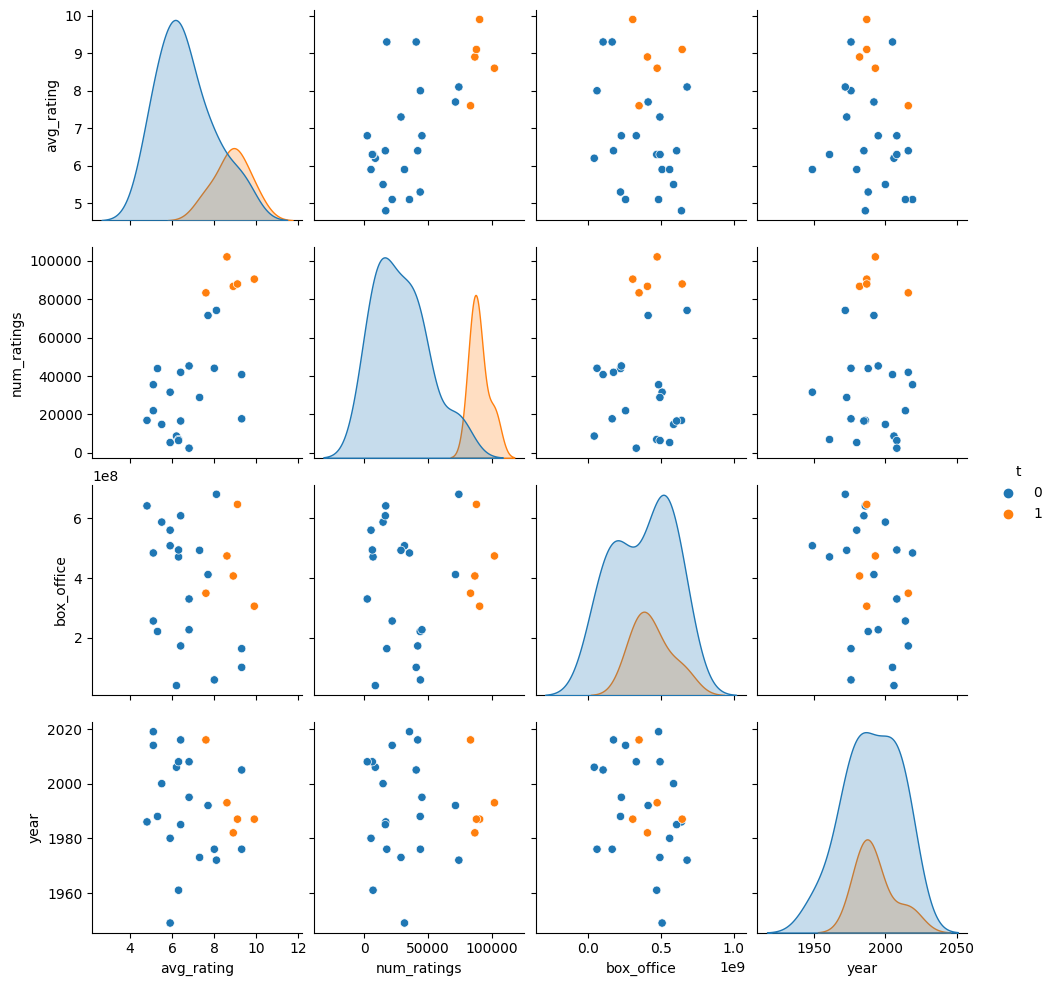

In [440]:
sns.pairplot(df[['avg_rating', 'num_ratings', 'box_office','year','t']],hue='t')

In [448]:
# now group and sort movies by genres and take random names from the dataset
from functools import reduce
df['genre_sets'] = reduce(lambda s,g: s+df[g].astype('str'),imdb_top_genres, df[imdb_top_genres[0]].astype('str'))
df['genre_sets'] = df['genre_sets'].apply(lambda gs: gs[1:])

# it can happen that we made a genre combination that doesn't exist in the imdb data
# so instead of all genres we only require one genre to match for title picking

available_movie_names = movie_ratings[['tconst', 'primaryTitle'] + imdb_top_genres]
# filter available movie names to a max character limit, in case we really want to display it
available_movie_names = available_movie_names[available_movie_names['primaryTitle'].str.len() < 20]

for genre_combo in sorted(df.genre_sets.unique(), key=lambda gs: gs.count('1'), reverse=True):
    qs = ' | '.join(map(lambda gf: f'{imdb_top_genres[gf[0]]} == {gf[1]}', enumerate(list(genre_combo))))
    movie_subset = available_movie_names.query(qs)
    num_titles_req = len(df[df.genre_sets == genre_combo])
    randids = np.random.choice(movie_subset['tconst'].to_list(), num_titles_req, replace=False)
    df.loc[df['genre_sets'] == genre_combo, 'tconst']= randids
    available_movie_names = available_movie_names.drop(labels= available_movie_names[available_movie_names.tconst.isin(randids)].index)

mdf = df.merge(movie_ratings[['tconst', 'primaryTitle']], how='inner', on='tconst', suffixes=('_df', '_mr'))
mdf

,year,avg_rating,num_ratings,box_office,t,year_z,avg_rating_z,num_ratings_z,box_office_z,Drama,Comedy,Documentary,Romance,Action,Crime,genre_sets,tconst,primaryTitle
0,2006,6.2,8705,40500154,0,0.837483,0.598448,1.053059,1.846198,0,0,1,0,0,0,001000,tt2401806,Cloistered Honey
1,1988,5.3,43867,221225576,0,0.164871,1.166251,0.093267,0.884680,1,0,0,0,0,0,100000,tt0267425,The Holy Year
2,1995,6.8,45230,227071198,0,0.220566,0.199434,0.137707,0.853580,1,0,0,0,0,0,100000,tt2065945,Gingerclown
3,1949,5.9,31552,507712162,0,2.374968,0.769902,0.308198,0.639521,1,0,0,0,0,0,100000,tt3317710,Drugs & Other Love
4,2016,6.4,41912,173074831,0,1.399336,0.461284,0.029545,1.140858,0,0,0,1,0,1,000101,tt12603018,Croma Kid
5,1961,6.3,6915,470434132,0,1.712189,0.510595,1.111392,0.441190,1,0,0,0,0,0,100000,tt0028634,Bill Cracks Down
6,2000,5.5,14769,586682974,0,0.493131,1.073624,0.855339,1.059671,1,0,0,0,0,1,100001,tt5606614,Wang Mao
7,2019,5.1,35461,483547442,0,1.602986,1.346589,0.180763,0.510957,1,1,0,0,0,0,110000,tt0085999,Nedeljni rucak
8,2008,6.3,6375,493564579,0,0.965489,0.528744,1.128999,0.564251,0,1,0,0,0,0,010000,tt3876400,Worlds on edge
9,2014,5.1,21920,256260410,0,1.313971,1.344679,0.622208,0.698284,1,0,0,0,0,0,100000,tt5065344,Chuzhoye imya


/usr/local/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


<Axes: xlabel='mdsx', ylabel='mdsy'>

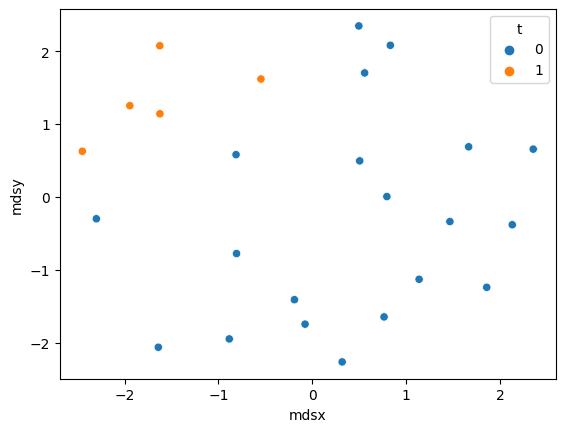

In [442]:
# quickly check the projection - we want the orange points bunched together
mds = MDS(n_components=2, metric=True, random_state=2,  dissimilarity="euclidean")
H_mds = mds.fit_transform(sps.zscore(samples))

sns.scatterplot(pd.DataFrame(data={
    'mdsx': H_mds[:,0], 
    'mdsy': H_mds[:,1], 
    't': t,
    'w': w,
    'x': x,
    'y': y,
    'z': z
}), x='mdsx', y='mdsy', hue='t')


In [445]:
mdf

,year,avg_rating,num_ratings,box_office,t,year_z,avg_rating_z,num_ratings_z,box_office_z,Drama,Comedy,Documentary,Romance,Action,Crime,genre_sets,tconst,primaryTitle
0,2006,6.2,8705,40500154,0,0.837483,0.598448,1.053059,1.846198,0,0,1,0,0,0,001000,tt16375578,Hannah Ha Ha
1,1988,5.3,43867,221225576,0,0.164871,1.166251,0.093267,0.884680,1,0,0,0,0,0,100000,tt3962164,Q-4: Dream Corporation
2,1995,6.8,45230,227071198,0,0.220566,0.199434,0.137707,0.853580,1,0,0,0,0,0,100000,tt0073678,El secreto inconfesable de un chico bien
3,1949,5.9,31552,507712162,0,2.374968,0.769902,0.308198,0.639521,1,0,0,0,0,0,100000,tt14740118,Righteous Thieves
4,2016,6.4,41912,173074831,0,1.399336,0.461284,0.029545,1.140858,0,0,0,1,0,1,000101,tt0079955,Stortjuven
5,1961,6.3,6915,470434132,0,1.712189,0.510595,1.111392,0.441190,1,0,0,0,0,0,100000,tt1885208,Brasch - Das Wünschen und das Fürchten
6,2000,5.5,14769,586682974,0,0.493131,1.073624,0.855339,1.059671,1,0,0,0,0,1,100001,tt3358534,Thiruvilaiyaadal Aarambam
7,2019,5.1,35461,483547442,0,1.602986,1.346589,0.180763,0.510957,1,1,0,0,0,0,110000,tt6973496,Ver Kaç
8,2008,6.3,6375,493564579,0,0.965489,0.528744,1.128999,0.564251,0,1,0,0,0,0,010000,tt0031211,Daughter of the Tong
9,2014,5.1,21920,256260410,0,1.313971,1.344679,0.622208,0.698284,1,0,0,0,0,0,100000,tt9471952,Sükut Evi


In [463]:
# now for the fun part, we have to create the glyph images
# haha fun part let's make actual glyph images!
from PIL import Image, ImageDraw, ImageFont


def add_corners(im, rad):
    circle = Image.new("L", (rad * 2, rad * 2), 0)
    draw = ImageDraw.Draw(circle)
    draw.ellipse((0, 0, rad * 2 - 1, rad * 2 - 1), fill=255)
    alpha = Image.new("L", im.size, 255)
    w, h = im.size
    alpha.paste(circle.crop((0, 0, rad, rad)), (0, 0))
    alpha.paste(circle.crop((0, rad, rad, rad * 2)), (0, h - rad))
    alpha.paste(circle.crop((rad, 0, rad * 2, rad)), (w - rad, 0))
    alpha.paste(circle.crop((rad, rad, rad * 2, rad * 2)), (w - rad, h - rad))
    im.putalpha(alpha)
    return im


def expand2square(pil_img, background_color=(0, 0, 0)):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result


def add_margin(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result


fw, fh = (500, 500)
margin = 15
field_alias = {
    "primaryTitle": "Title",
    "year": "Year",
    "avg_rating": "Rating",
    "num_ratings": "# Votes",
    "box_office": "Profit",
}

for i in mdf.index:
    movie = mdf.loc[i]
    img = Image.new(mode="RGB", size=(fw, fh))
    img = add_corners(img, 30)
    fnt = ImageFont.truetype("Arial.ttf", 40)
    d = ImageDraw.Draw(img)

    for j, field in enumerate(
        ["primaryTitle", "year", "avg_rating", "num_ratings", "box_office"]
    ):
        fmtstr = str(movie[field])
        match field:
            case "avg_rating":
                fmtstr = "{:.2f}".format(movie[field])
            case "num_ratings":
                fmtstr = "{:,}".format(movie[field])
            case "box_office":
                fmtstr = "$ {:,}".format(movie[field])
        d.text(
            (margin, 100 + (j + 1) * 45 + (j * 10)),
            f"{field_alias[field]}: {fmtstr}",
            font=fnt,
            fill=(255, 255, 255),
            anchor="ls",
        )

    img.save(f'./imgs/{movie["tconst"]}_thumb.png', "PNG")

if False:
    for i, c in enumerate(movie_ratings["cover"]):
        movie = movie_ratings.iloc[i]
        tconst, ext = c.split(".")
        with Image.open(f"./covers/{c}") as im:
            im2 = expand2square(im.copy())
            im2 = im2.resize((300, 300))
            im2 = add_margin(im2, 50, 75, 100, 75, (0, 0, 0))
            im2 = add_corners(im2, 30)
            w, h = im2.size
            print(tconst)

            fnt = ImageFont.truetype("Arial.ttf", 40)
            d = ImageDraw.Draw(im2)
            d.text(
                (fw / 2, 45),
                movie["startYear"],
                font=fnt,
                fill=(255, 255, 255),
                anchor="ms",
            )
            d.text(
                (margin, 50 + 395),
                "{:.2f}".format(movie["averageRating"]),
                font=fnt,
                fill=(255, 255, 255),
                anchor="ls",
            )
            d.text(
                (fw - margin, 50 + 395),
                "{:,}".format(movie["numVotes"]),
                font=fnt,
                fill=(255, 255, 255),
                anchor="rs",
            )
            y = 325 + 50
            offset = 85
            for star in range(round(movie["averageRating"])):
                x = offset + star * 27 + max(0, star - 1) * 2
                d.ellipse((x, y, x + 25, y + 25), fill=(255, 255, 0))
            for star in range(round(movie["averageRating"]), 10):
                x = offset + star * 27 + max(0, star - 1) * 2
                d.ellipse((x, y, x + 25, y + 25), outline=(255, 255, 0))

            im2.save(f"./imdb10/{tconst}_thumb.png", "PNG")
            # TODO add path to dataframe